In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import seaborn as sns
from sklearn.linear_model import LinearRegression
import datetime
sns.set()

In [62]:
df = pd.read_csv('20201208_sequoia_dispense_logs.csv')
df['local_ts'] = pd.to_datetime(df['local_ts'])
bad_valve = 18

In [63]:
# print(df.shape)
df = df.loc[(df['device_task_view_id'] != 'calibrate')
           & (df['device_task_view_id'] != 'prep_reagents')
           & (df['device_task_top_level'] != 'Calibrate Fluidics')
           & (df['device_task_top_level'] != 'Fluidics Preflight')].copy()

In [64]:
# Define Color and Marker map for each valve
valve_color_map = {1:['#CCFF00', '.'],
                  2: ['#CCCC00', 'v'],
                  3: ['#CC9900', 's'],
                  4: ['#CC6600', '1'],
                  5: ['#CC3300', 'P'],
                  6: ['#CC0000', 'X'],
                  7: ['#660000', 'd'],
                  8: ['#663300', '.'],
                  9: ['#666600', 'v'],
                  10:['#669900', '1'],
                  11:['#66CC00', 's'],
                  12:['#66FF00', 'P'],
                  13:['#1A237E', 'X'],
                  14:['#00FF33', 'd'],
                  15:['#00FF00', '.'],
                  16:['#00CC00', 'v'],
                  17:['#009900', 's'],
                  18:['#006600', '1'],
                  19:['#003300', 'P'],
                  20:['#0000FF', 'X']}

reagent_map = [1, 2, 3, 4, 5, 6, 8, 9, 10, 13, 18]

In [65]:
# Define function to parse differential pressure sensor data from logs
def parse_diff_pressure(df):
    dispenses_full = []
    for i in range(len(df)):
        dict_string = df['fc_sensor_data'].iloc[i]
        dispenses_full.append(ast.literal_eval(dict_string))

    curves = []
    baselines = []
    peaks = []
    AUCs = []
    gauge_pressures = []
    abs_pressures = []
    lengths = []
    
    for dispense in dispenses_full:
        length = len(dispense)
        single_dispense = []
        try:
            gauge_pressure = dispense[1][1]['gauge_pressure_psi']
            abs_pressure = dispense[1][1]['abs_pressure_bar']
        except KeyError:
            gauge_pressure = dispense[1][1]['state']['gauge_pressure_psi']
            abs_pressure = dispense[1][1]['state']['abs_pressure_bar']
        gauge_pressures.append(gauge_pressure)
        abs_pressures.append(abs_pressure)
        for point in dispense:
            try:
                single_dispense.append(-1 * point[1]['state']['diff_pressure'])
            except KeyError:
                try:
                    single_dispense.append(-1 * point[1]['diff_pressure'])
                except KeyError:
                    print("Key Error: {}".format(point))
                    pass
        try:
            baseline=single_dispense[0]
            baselines.append(baseline)
            for i in range(len(single_dispense)):
                single_dispense[i] = single_dispense[i] - baseline
            peaks.append(max(single_dispense))
            AUCs.append(np.trapz(single_dispense))
            curves.append(single_dispense)
            lengths.append(length)
        
        except IndexError:
            print("IndexError: {}".format(single_dispense))
            curves.append([0])
            baselines.append(0)
            peaks.append(0)
            AUCs.append(0)
            lengths.append(0)

    dict_to_df = {'pressure_curves': curves,
                  'length': lengths,
                 'baseline': baselines,
                 'peak': peaks,
                 'AUC': AUCs,
                 'gauge_pressure': gauge_pressures,
                 'abs_pressure': abs_pressures}
    curve_df = pd.DataFrame(dict_to_df)
    return curve_df



In [66]:
# Concatenate data to original df
curve_df = parse_diff_pressure(df)
df.reset_index(inplace=True, drop=True)
dfs = [df, curve_df]
full_df = pd.concat(dfs, axis=1)

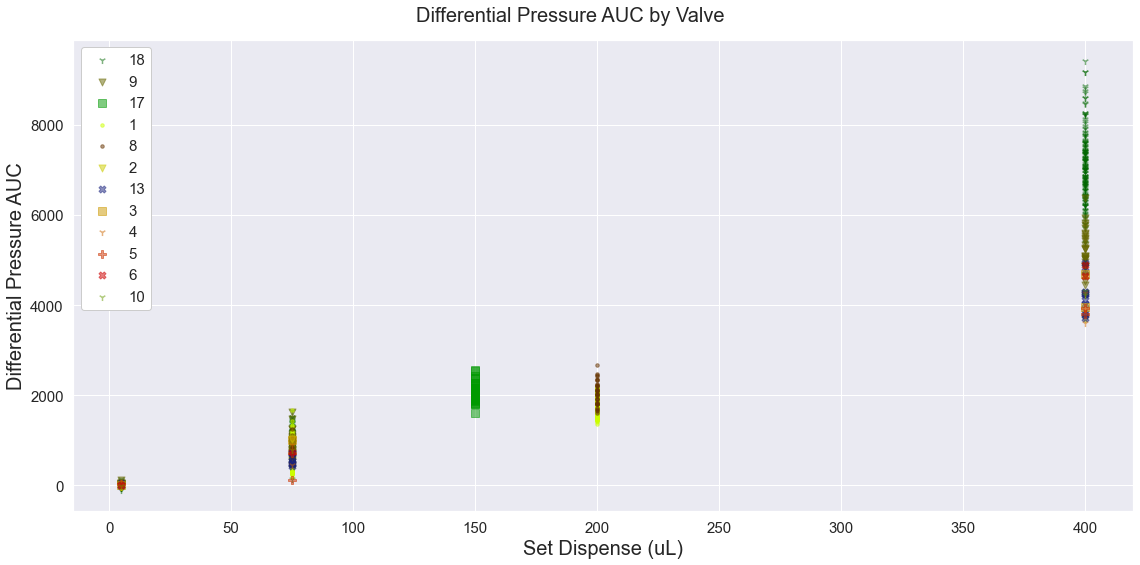

In [67]:
# AUC vs set dispense volume
fig, ax = plt.subplots(figsize=(16, 8))
dis_only = full_df.loc[full_df['dispense_type'] == 'reagent'].copy()
valves = dis_only['valve_num'].unique()
for valve in valves:
    valve_df = dis_only.loc[dis_only['valve_num'] == valve].copy()
    ax.scatter(valve_df['volume_ul'], valve_df['AUC'], label="{}".format(valve), 
                         color=valve_color_map[valve][0], marker=valve_color_map[valve][1], s=50, alpha=0.5)

ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Set Dispense (uL)', fontsize=20)
plt.ylabel('Differential Pressure AUC', fontsize=20)
fig.suptitle('Differential Pressure AUC by Valve', fontsize=20)
ax.legend(facecolor='white', framealpha=1, fontsize=15)
plt.tight_layout()
plt.show()

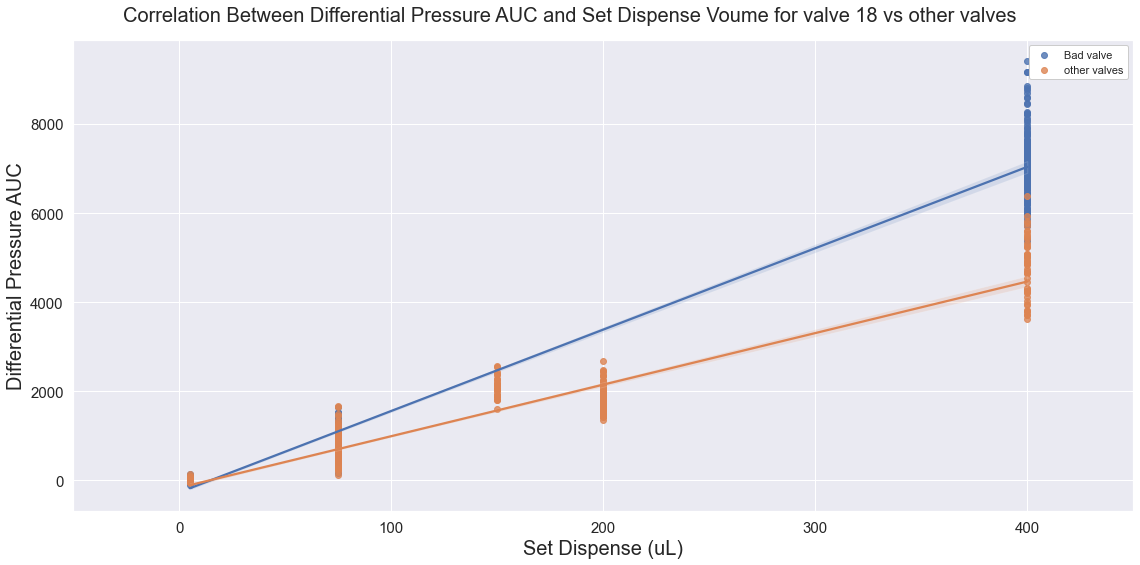

In [68]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.regplot(x=dis_only.loc[dis_only['valve_num'] == bad_valve]['volume_ul'], 
            y=dis_only.loc[dis_only['valve_num'] == bad_valve]['AUC'], 
            label = 'Bad valve')
sns.regplot(x=dis_only.loc[dis_only['valve_num'] != bad_valve]['volume_ul'], 
            y=dis_only.loc[dis_only['valve_num'] != bad_valve]['AUC'], 
            label='other valves')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Set Dispense (uL)', fontsize=20)
plt.ylabel('Differential Pressure AUC', fontsize=20)
fig.suptitle('Correlation Between Differential Pressure AUC and Set Dispense Voume for valve {} vs other valves'.format(bad_valve), 
             fontsize=20)
ax.set(xlim=(-50, 450))
ax.legend(facecolor='white', framealpha=1)
plt.tight_layout()
plt.show()

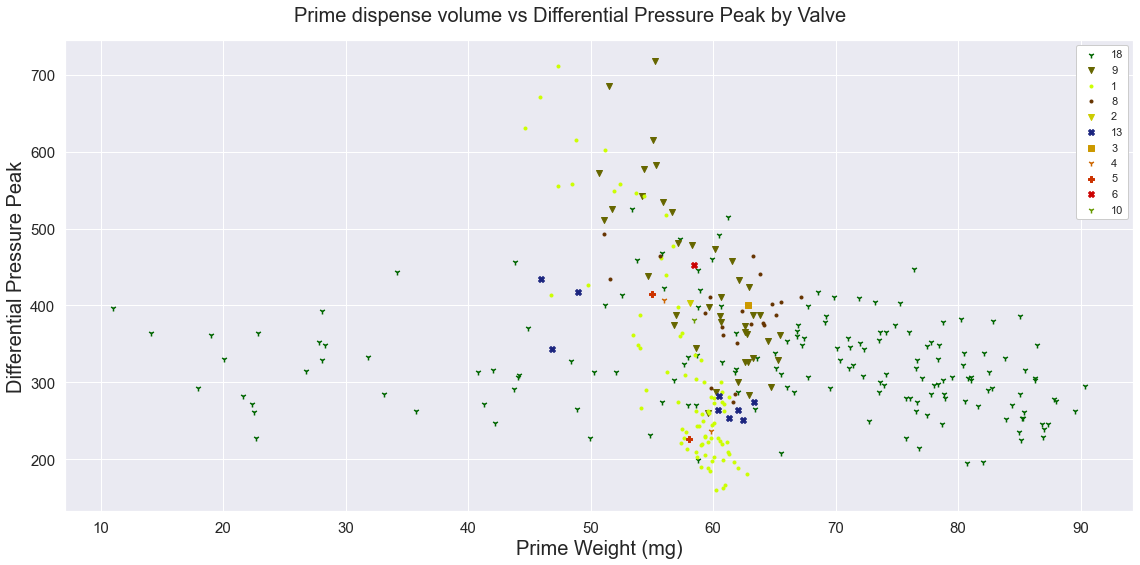

In [69]:
fig, ax = plt.subplots(figsize=(16, 8))
primes_df = full_df.loc[full_df['volume_ul'] == 75].copy()
valves = primes_df['valve_num'].unique()
for valve in valves:
    valve_df = primes_df.loc[primes_df['valve_num'] == valve].copy()
    ax.scatter(valve_df['weight_mg'], valve_df['peak'], label="{}".format(valve), 
               color=valve_color_map[valve][0], marker=valve_color_map[valve][1])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Prime Weight (mg)', fontsize=20)
plt.ylabel('Differential Pressure Peak', fontsize=20)
fig.suptitle('Prime dispense volume vs Differential Pressure Peak by Valve', fontsize=20)
plt.tight_layout()
ax.legend(facecolor='white', framealpha=1)
plt.show()

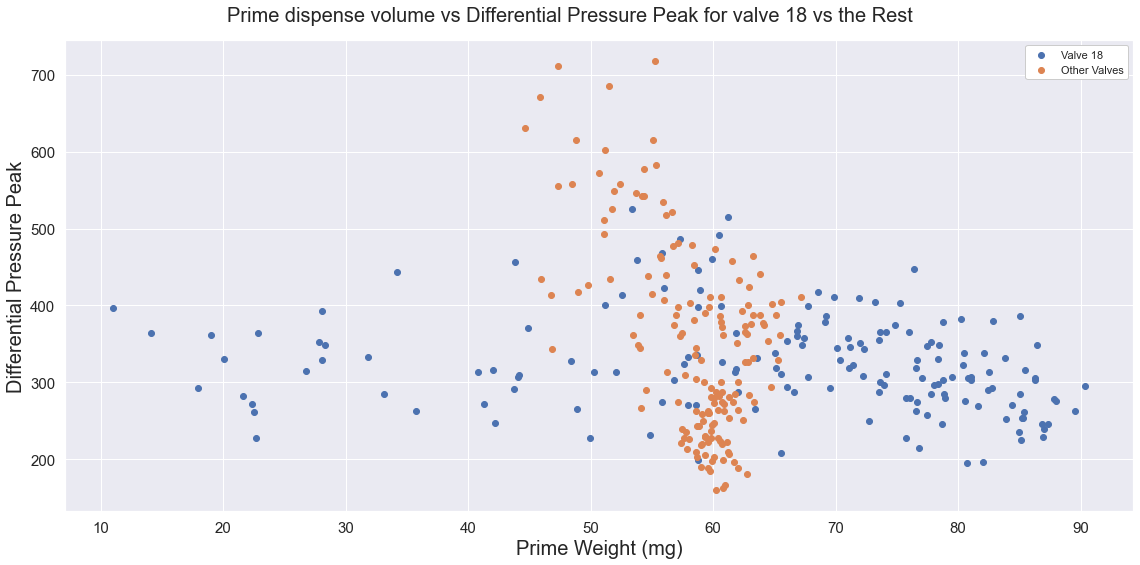

In [70]:
fig, ax = plt.subplots(figsize=(16, 8))
primes_df = full_df.loc[full_df['volume_ul'] == 75].copy()
valve_df = primes_df.loc[primes_df['valve_num'] == bad_valve].copy()
other_df = primes_df.loc[primes_df['valve_num'] != bad_valve].copy()
ax.scatter(valve_df['weight_mg'], valve_df['peak'], label='Valve {}'.format(bad_valve))
ax.scatter(other_df['weight_mg'], other_df['peak'], label='Other Valves')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Prime Weight (mg)', fontsize=20)
plt.ylabel('Differential Pressure Peak', fontsize=20)
fig.suptitle('Prime dispense volume vs Differential Pressure Peak for valve {} vs the Rest'.format(bad_valve), fontsize=20)
plt.tight_layout()
ax.legend(facecolor='white', framealpha=1)
plt.show()

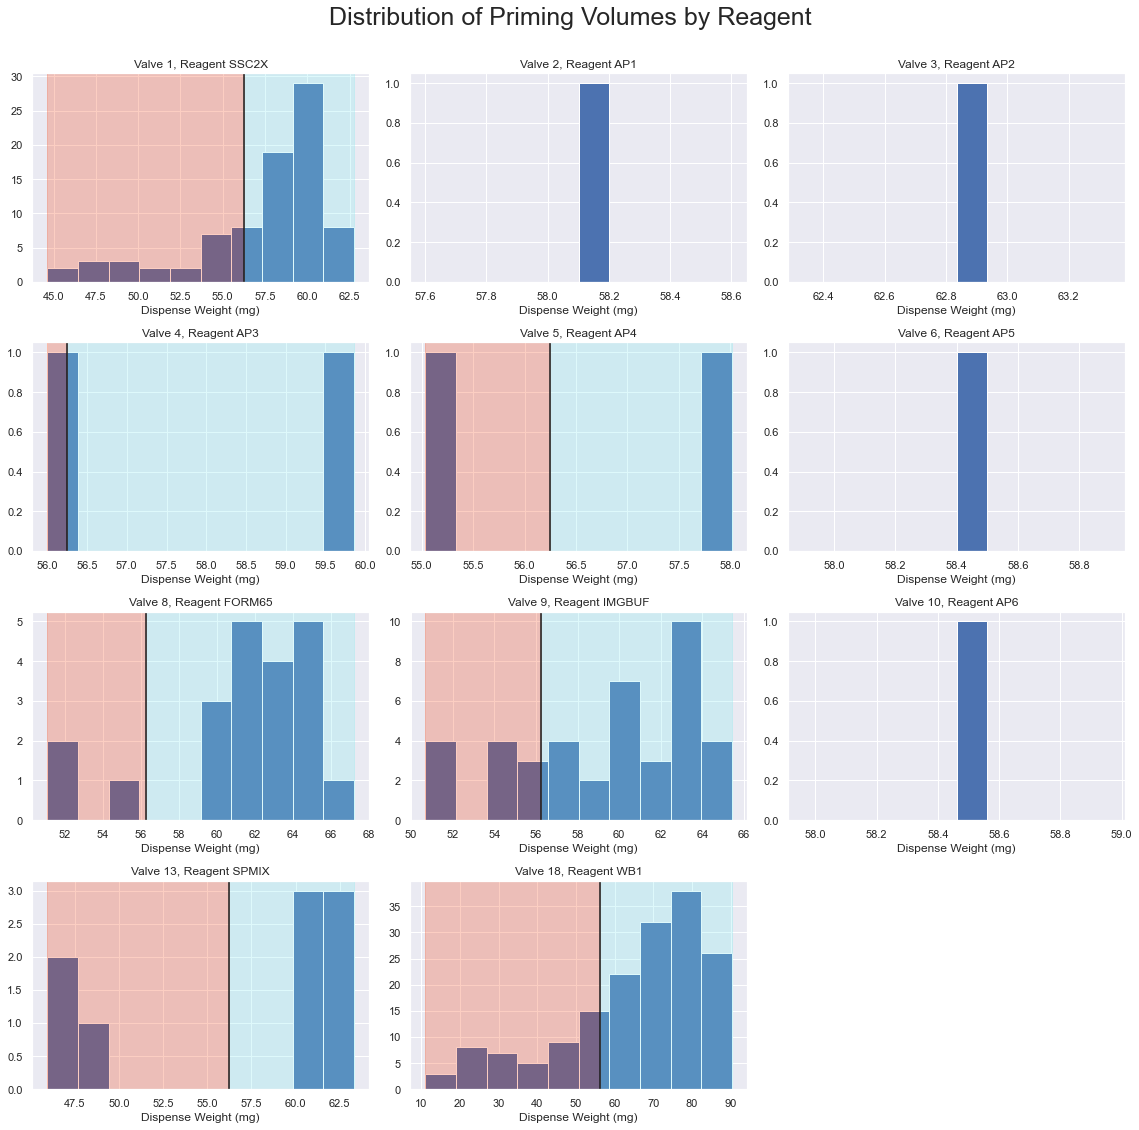

In [71]:
primes_df = full_df.loc[full_df['volume_ul'] == 75].copy()
fig = plt.figure(figsize=(16, round(len(reagent_map)/3)*4))
for valve, i in zip(reagent_map, range(1, len(reagent_map) + 1)):
    ax = fig.add_subplot(round(len(reagent_map)/3), 3, i)
    temp_df = primes_df.loc[primes_df['valve_num']==valve]
    ax.hist(temp_df['weight_mg'])
    ax.set(xlabel='Dispense Weight (mg)', 
           title='Valve {}, Reagent {}'.format(valve, temp_df['reagent'].iloc[0]))
    if temp_df.shape[0] > 1:
        ax.axvspan(temp_df['weight_mg'].min(), 56.25, alpha=0.25, color='#F43D0C')
        ax.axvspan(56.25, temp_df['weight_mg'].max(), alpha=0.25, color='#7DEAF0')
        ax.axvline(75 - 75*.25, color='k')
fig.suptitle('Distribution of Priming Volumes by Reagent\n', fontsize=25)
plt.tight_layout()
plt.show()

In [72]:
stats_df = primes_df.groupby('reagent')['weight_mg'].describe()
stats_df.drop(columns=['25%', '50%', '75%'])

count       mean        std        min        max
reagent                                                   
AP1        1.0  58.101648        NaN  58.101648  58.101648
AP2        1.0  62.834535        NaN  62.834535  62.834535
AP3        2.0  57.929431   2.726905  56.001218  59.857644
AP4        2.0  56.525557   2.107154  55.035574  58.015539
AP5        1.0  58.399952        NaN  58.399952  58.399952
AP6        1.0  58.461458        NaN  58.461458  58.461458
FORM65    21.0  61.319730   4.186905  51.077662  67.210687
IMGBUF    41.0  59.287964   4.212425  50.684024  65.420863
SPMIX      9.0  56.858885   7.295932  45.960362  63.298905
SSC2X     83.0  57.370912   4.121575  44.637983  62.757653
WB1      165.0  64.937593  18.849740  11.034177  90.336945

*All valves except for AP1, AP2, AP5, and AP6 required at least one retry of the prime. The mean priming volume was less than 75ul for all reagents.*

In [73]:
def priming_stats(df, valve = 0):
    try:
        bad_valve_df = df.loc[df['valve_num']==valve].copy()
        total_prime_bad = bad_valve_df.shape[0]
        total_bad_prime_bad = bad_valve_df.loc[bad_valve_df['weight_mg'] < 56.25].shape[0]
        total_good_prime_bad = bad_valve_df.loc[bad_valve_df['weight_mg'] >= 56.25].shape[0]
        ratio_bad = total_bad_prime_bad / total_good_prime_bad

        print(total_prime_bad, total_bad_prime_bad, total_good_prime_bad, ratio_bad)    
    except ZeroDivisionError:
        pass
    
    other_valve_df = df.loc[df['valve_num']!=valve].copy()
    total_prime_other = other_valve_df.shape[0]
    total_bad_prime_other = other_valve_df.loc[other_valve_df['weight_mg'] < 56.25].shape[0]
    total_good_prime_other = other_valve_df.loc[other_valve_df['weight_mg'] >= 56.25].shape[0]
    ratio_other = total_bad_prime_other / total_good_prime_other
    
    print(total_prime_other, total_bad_prime_other, total_good_prime_other, ratio_other)
    
    dict_to_df = {}
    
    
    
priming_stats(primes_df, bad_valve)

165 41 124 0.33064516129032256
162 42 120 0.35


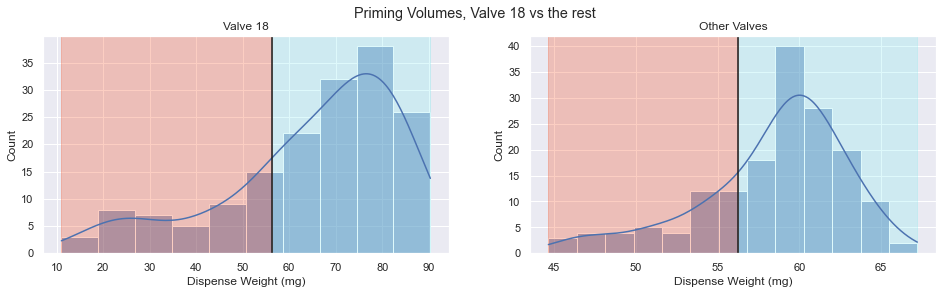

In [74]:
# fig, ax = plt.subplots()
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 2, 1)
temp_df = primes_df.loc[primes_df['valve_num']==bad_valve]
sns.histplot(temp_df['weight_mg'], kde=True)
ax.set(xlabel='Dispense Weight (mg)', title='Valve {}'.format(bad_valve))
ax.axvspan(temp_df['weight_mg'].min(), 56.25, alpha=0.25, color='#F43D0C')
ax.axvspan(56.25, temp_df['weight_mg'].max(), alpha=0.25, color='#7DEAF0')
ax.axvline(75 - 75*.25, color='k')

ax = fig.add_subplot(1, 2, 2)
temp_df = primes_df.loc[primes_df['valve_num']!=bad_valve]
sns.histplot(temp_df['weight_mg'], kde=True)
ax.set(xlabel='Dispense Weight (mg)', title='Other Valves')
ax.axvspan(temp_df['weight_mg'].min(), 56.25, alpha=0.25, color='#F43D0C')
ax.axvspan(56.25, temp_df['weight_mg'].max(), alpha=0.25, color='#7DEAF0')
ax.axvline(75 - 75*.25, color='k')
fig.suptitle('Priming Volumes, Valve {} vs the rest'.format(bad_valve))
plt.show()

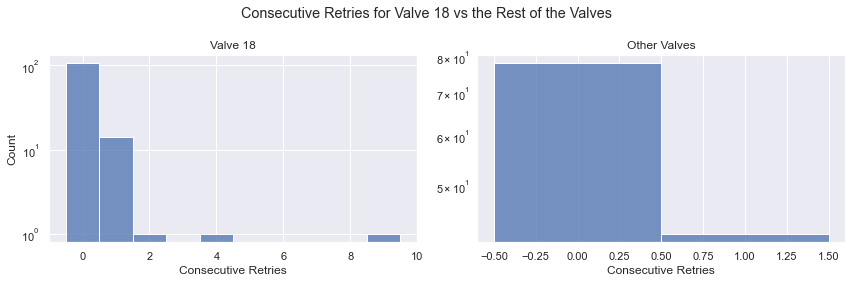

In [89]:
# Determine retries
fig = plt.figure(figsize=(12, 4))
temp_df = full_df.loc[full_df['valve_num'] == bad_valve].copy()
i = 0
retries = []
while i < temp_df.shape[0]:
    counter = 0
    if temp_df['volume_ul'].iloc[i] == 5:
        j = 1
        while (temp_df['volume_ul'].iloc[i + j] == 5 or temp_df['volume_ul'].iloc[i + j] == 75):
            counter += 1
            j += 1
        if retries == 1:
            retries.append(0)
        else:
            retries.append(int((counter/3)+(1/3)))
        i = i+j
    else:
        i += 1
ax = fig.add_subplot(1, 2, 1)
# fig, ax = plt.subplots()
sns.histplot(retries, discrete=True)
ax.set(yscale='log')
ax.set(xlabel='Consecutive Retries', title='Valve {}'.format(bad_valve))

temp_df = full_df.loc[full_df['valve_num'] != bad_valve].copy()
i = 0
retries = []
while i < temp_df.shape[0]:
    counter = 0
    if temp_df['volume_ul'].iloc[i] == 5:
        j = 1
        while (temp_df['volume_ul'].iloc[i + j] == 5 or temp_df['volume_ul'].iloc[i + j] == 75):
            counter += 1
            j += 1
        if retries == 1:
            retries.append(0)
        else:
            retries.append(int((counter/3)+(1/3)))
        i = i+j
    else:
        i += 1
ax = fig.add_subplot(1, 2, 2)
sns.histplot(retries, discrete=True)
ax.set(yscale='log')
ax.set(xlabel='Consecutive Retries', ylabel='', title='Other Valves')
fig.suptitle('Consecutive Retries for Valve {} vs the Rest of the Valves'.format(bad_valve))
plt.tight_layout()
plt.show()

{0: 'b', 75: 'g', 400: 'r', 5: 'k', 150: 'y', 200: 'orange'}


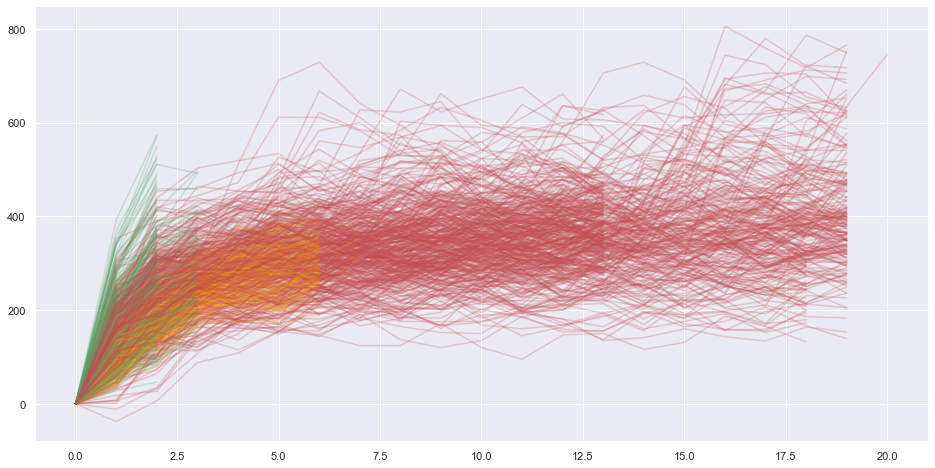

In [80]:
dispenses_full = []
dispense_weight = []
dispense_index = df.index
for i in range(len(df)):
    dict_string = df['fc_sensor_data'].iloc[i]
    dispenses_full.append(ast.literal_eval(dict_string))
    dispense_weight.append(df['volume_ul'].iloc[i])
# print(dispense_index)

all_dispense = []
final_weight_mg = []
for dispense, weight_mg in zip(dispenses_full, dispense_weight):
#     print(dispense)
    single_dispense = []
#     print(counter)
    for point in dispense:
#         print(point[1])
        try:
#             print(-1 * point[1]['state']['diff_pressure'])
            single_dispense.append(-1 * point[1]['state']['diff_pressure'])
        except KeyError:
#             print("didn't work")
            pass
#     print(single_dispense)
    try:
        baseline=single_dispense[0]
        for i in range(len(single_dispense)):
            single_dispense[i] = single_dispense[i] - baseline
        all_dispense.append(single_dispense)
        final_weight_mg.append(weight_mg)
    except IndexError:
#         print("Dispense not long enough for multiple data points")
        all_dispense.append([0])
        final_weight_mg.append(0)

dict_to_df = {'pressure curves': all_dispense,
             'intended dispense volume': final_weight_mg}
curve_df = pd.DataFrame(dict_to_df)
curve_df.head()
values = curve_df['intended dispense volume'].unique()
colors = ['b', 'g', 'r', 'k', 'y', 'orange', 'pink', 'purple', 'lime']
value_color_dict = dict(zip(values, colors))
print(value_color_dict)

fig, ax = plt.subplots(figsize=(16,8))
for i in range(curve_df.shape[0]):
    curve = curve_df['pressure curves'].iloc[i]
#     print(len(curve))
    ax.plot(range(len(curve)), curve, 
            color='{}'.format(value_color_dict[curve_df['intended dispense volume'].iloc[i]]),
           alpha=0.25)

In [81]:
# Find Objective wetting points
full_df['local_ts'] = pd.to_datetime(full_df['local_ts'])
imaging_df = full_df.loc[full_df['device_task_running'] == 'Wet Objective'].copy()
first_row = full_df.iloc[[0]]
last_row = full_df.iloc[[-1]]
imaging_df = pd.concat([first_row, imaging_df, last_row]).reset_index(drop=True)
imaging_df.head()
wetting_ts = imaging_df['local_ts']

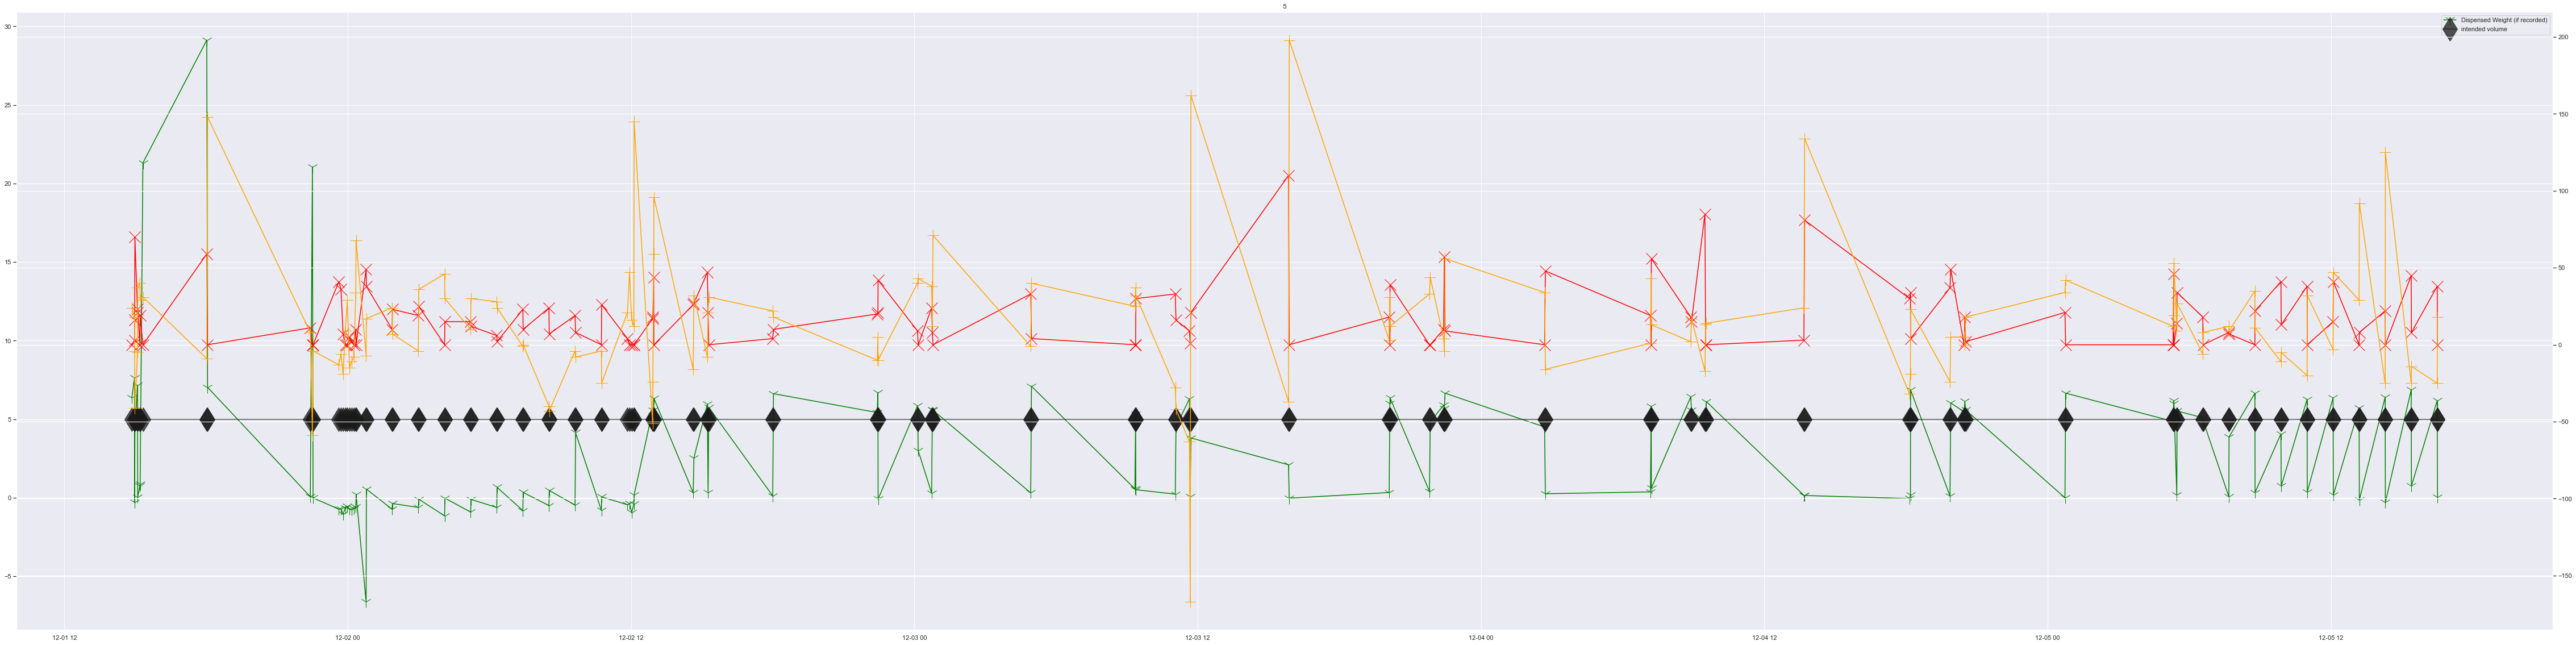

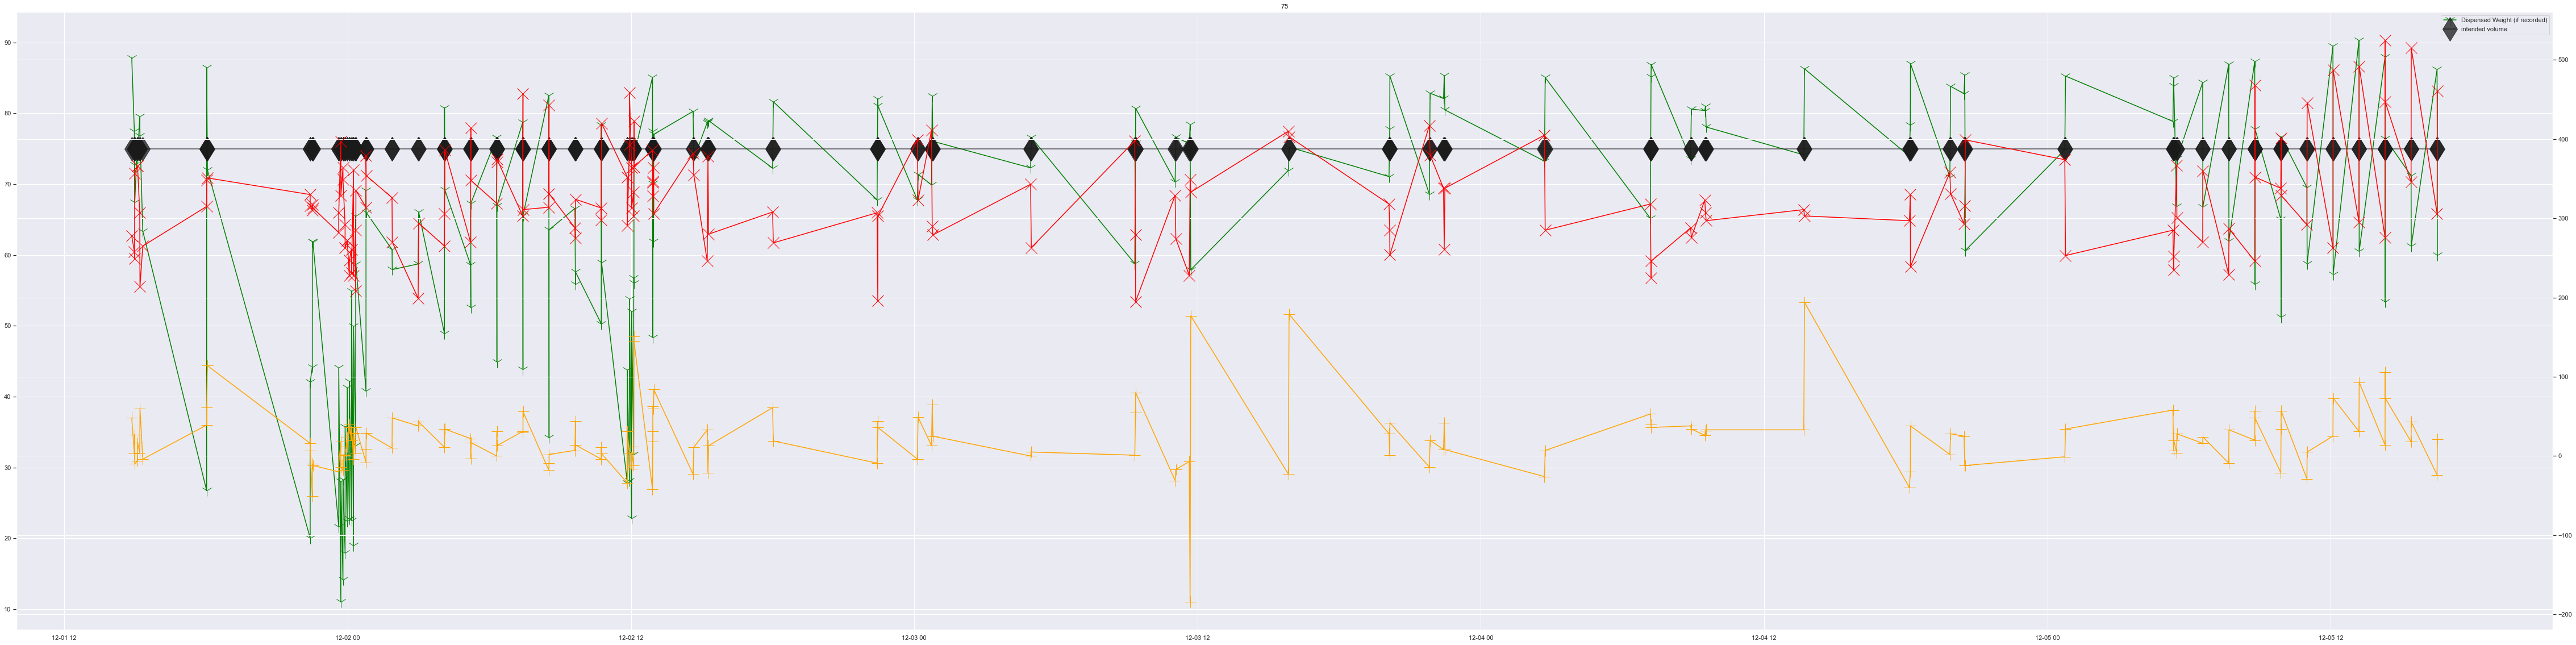

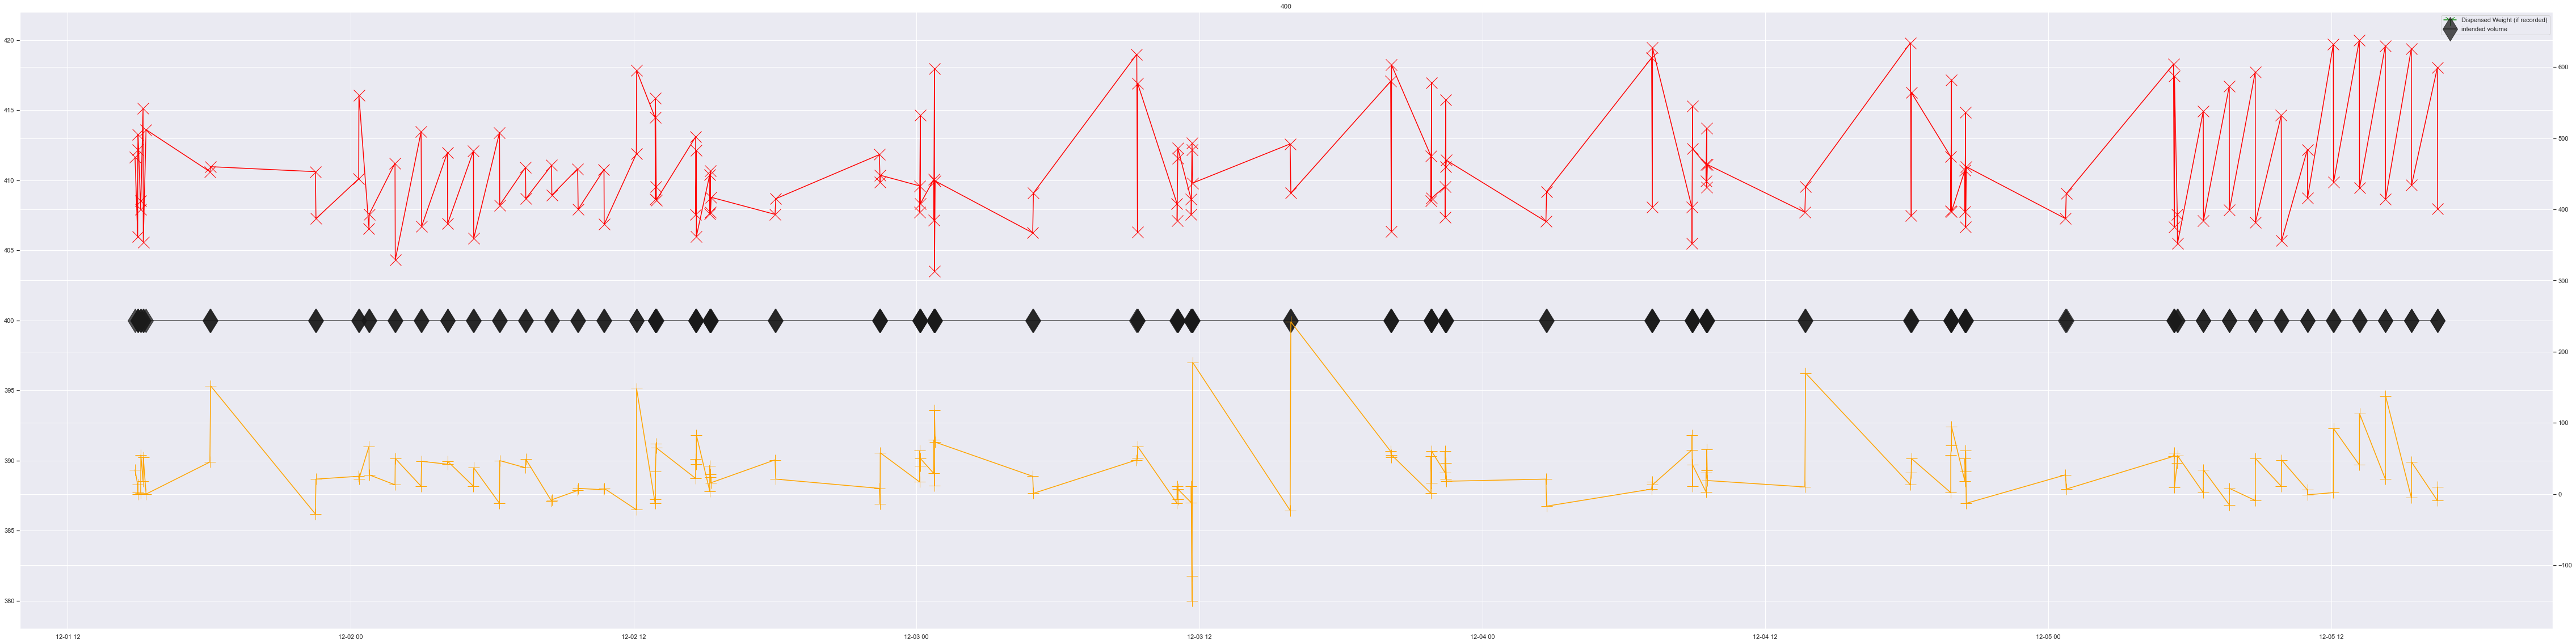

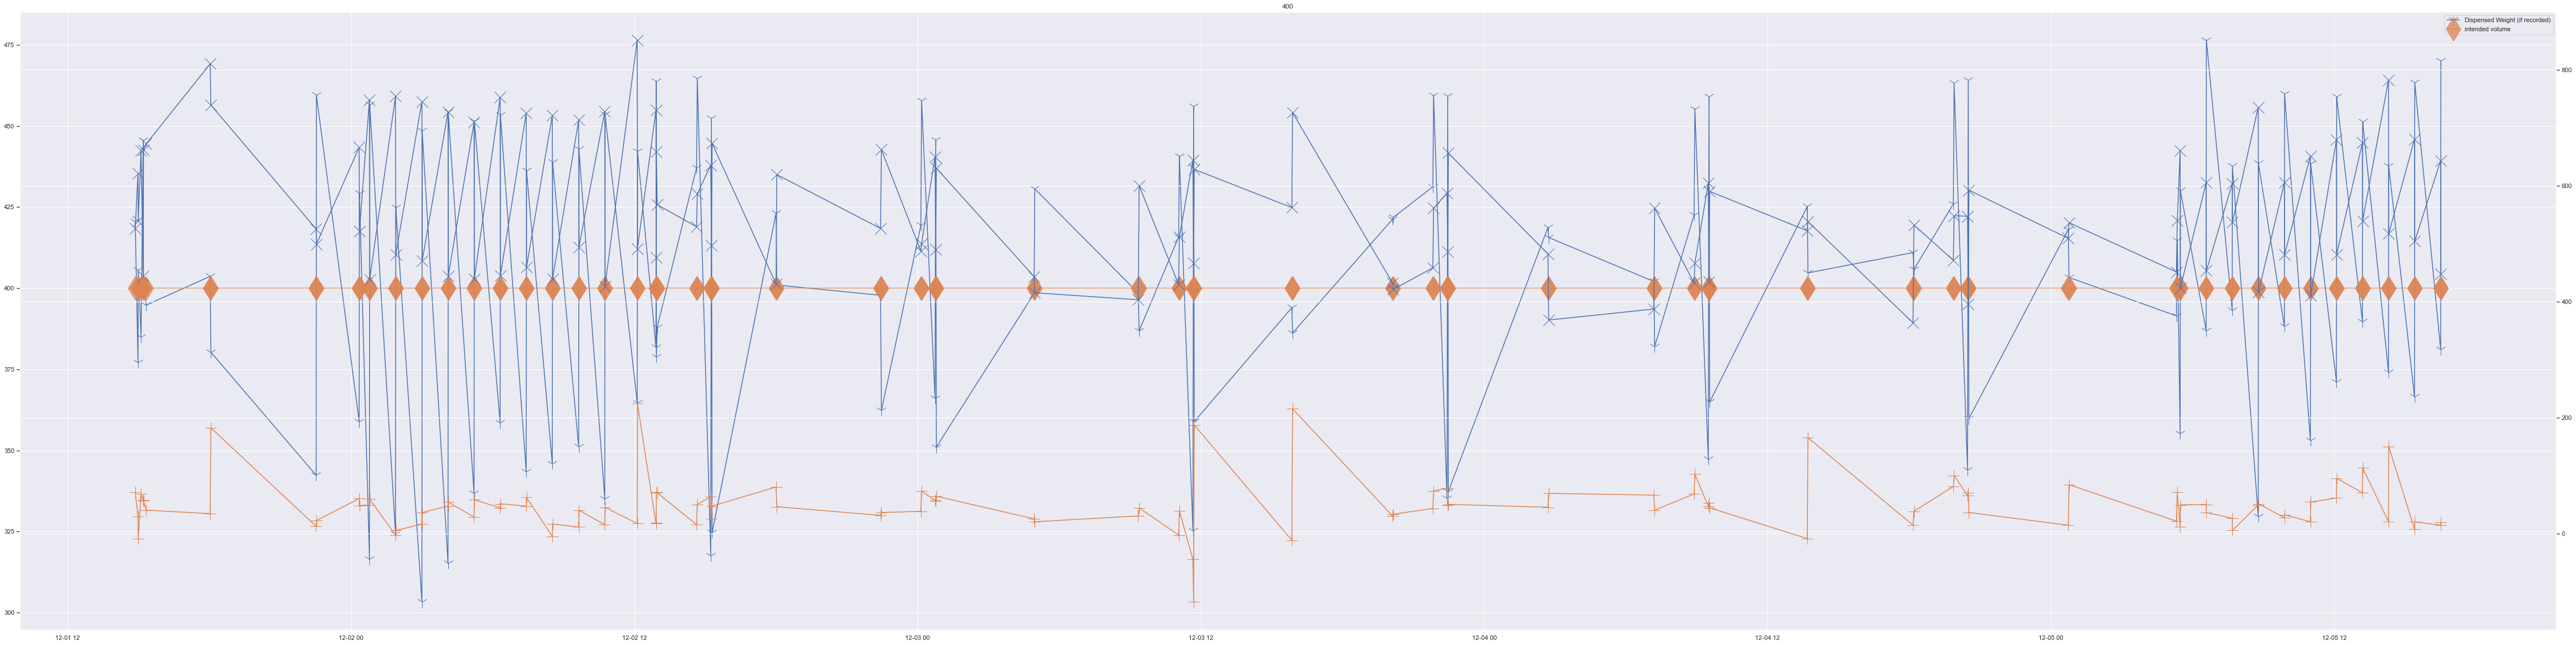

In [90]:
df_18 = full_df.loc[(full_df['valve_num'] == bad_valve) & (full_df['dispense_type'] == 'reagent')].copy()
df_18_flush = full_df.loc[(full_df['valve_num'] == bad_valve) & (full_df['dispense_type'] == 'flush')].copy()
volumes = df_18['volume_ul'].unique()
for volume in volumes:
    temp_df = df_18.loc[df_18['volume_ul'] == volume].copy()
    temp_df.to_csv('time_Series.csv')
    fig, ax = plt.subplots(figsize=(80, 20))
    ax2 = ax.twinx()
#     ax2 = ax.twinx()
    ax2.plot(temp_df['local_ts'], temp_df['peak'], marker='x', label='Diff Pressure Peak', markersize=20, color='red')
    ax2.plot(temp_df['local_ts'], temp_df['baseline'], marker='+', label='Baseline', markersize=20, color='orange')
    ax.plot(temp_df['local_ts'], temp_df['weight_mg'], marker='1', label='Dispensed Weight (if recorded)', markersize=20, color='green')
    ax.plot(temp_df['local_ts'], temp_df['volume_ul'], marker='d', label='intended volume', markersize=30, alpha=0.75, color='k')
#     for i in range(len(wetting_ts) - 1):
#         ax.axvspan(wetting_ts[i], wetting_ts[i + 1], alpha=0.25)
    ax.set(title='{}'.format(volume))
    ax.legend()
    plt.show()
    
fig, ax = plt.subplots(figsize=(80, 20))
ax2 = ax.twinx()
ax2.plot(df_18_flush['local_ts'], df_18_flush['peak'], marker='x', label='Diff Pressure Peak', markersize=20)
ax2.plot(df_18_flush['local_ts'], df_18_flush['baseline'], marker='+', label='Baseline', markersize=20)
ax.plot(df_18_flush['local_ts'], df_18_flush['weight_mg'], marker='1', label='Dispensed Weight (if recorded)', markersize=20)
ax.plot(df_18_flush['local_ts'], df_18_flush['volume_ul'], marker='d', label='intended volume', markersize=30, alpha=0.75)
# for i in range(len(wetting_ts) - 1):
#     ax.axvspan(wetting_ts[i], wetting_ts[i + 1], alpha=0.5)
ax.set(title='{}'.format(volume))
sns.set()
ax.legend()
plt.show()
    # ax.set(xscale='log')

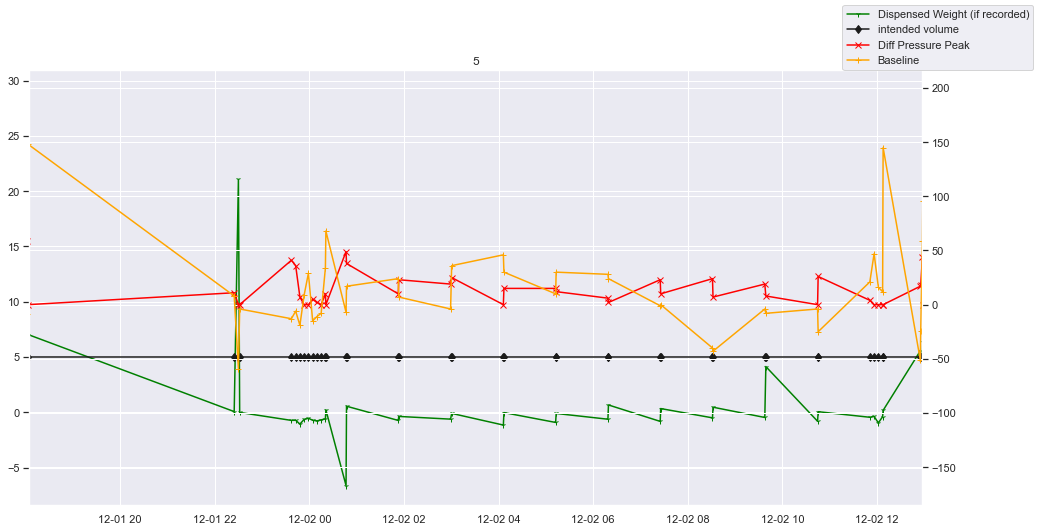

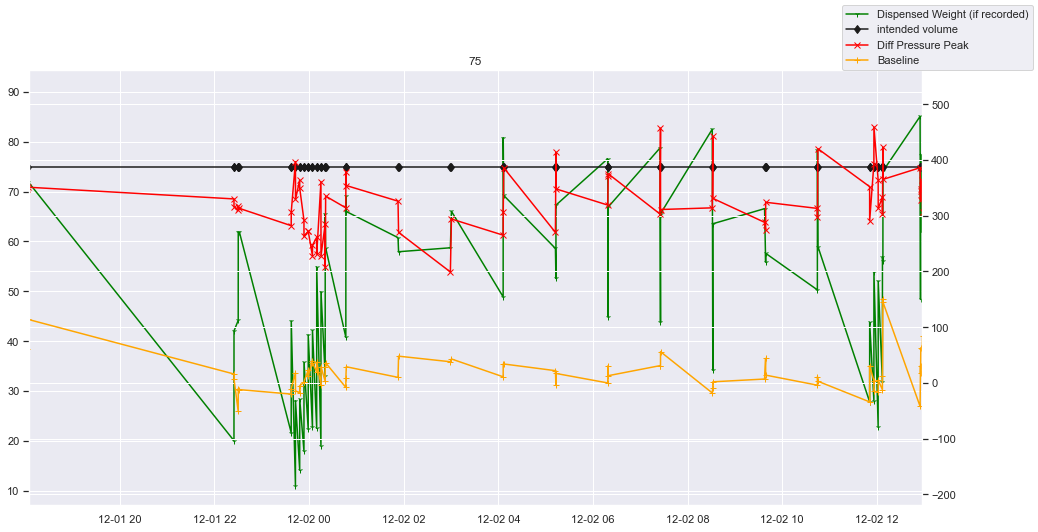

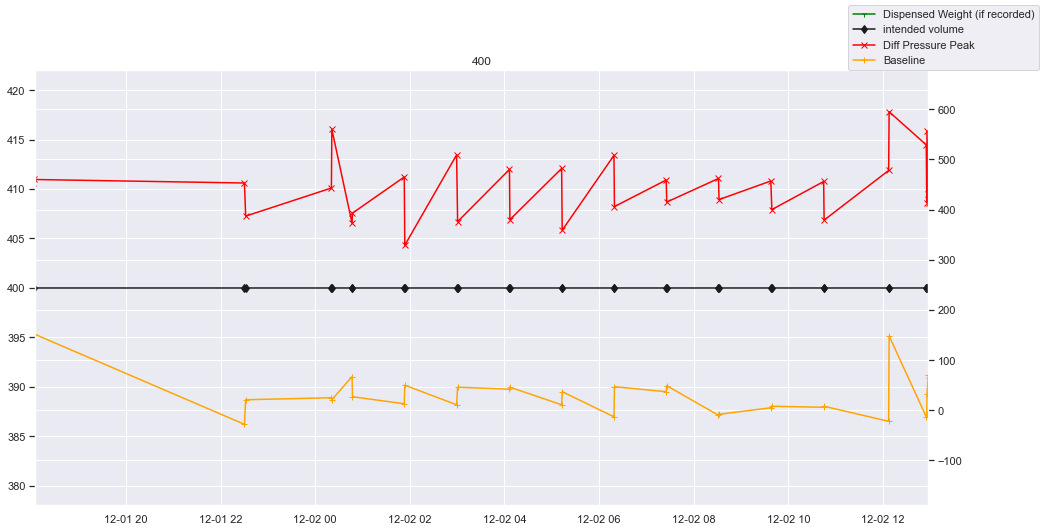

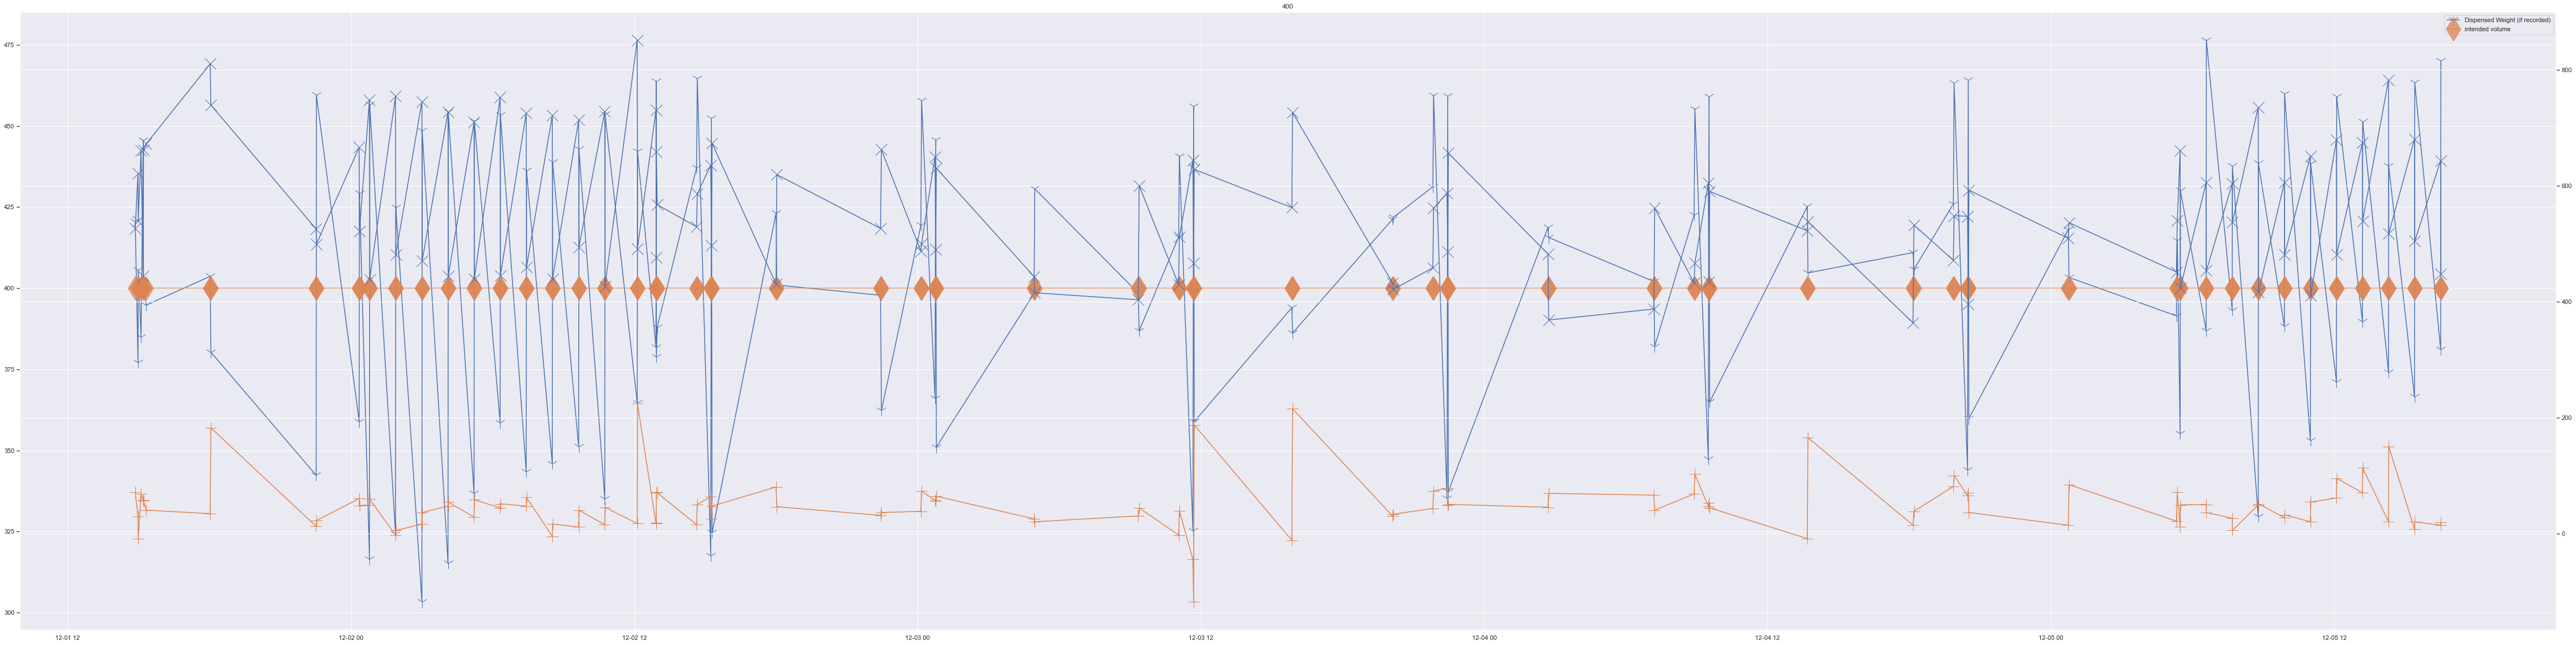

In [83]:
df_18 = full_df.loc[(full_df['valve_num'] == 18) & (full_df['dispense_type'] == 'reagent')].copy()
df_18_flush = full_df.loc[(full_df['valve_num'] == 18) & (full_df['dispense_type'] == 'flush')].copy()
volumes = df_18['volume_ul'].unique()
for volume in volumes:
    temp_df = df_18.loc[df_18['volume_ul'] == volume].copy()
    temp_df.to_csv('time_Series.csv')
    fig, ax = plt.subplots(figsize=(16, 8))
    ax2 = ax.twinx()
#     ax2 = ax.twinx()
    ax2.plot(temp_df['local_ts'], temp_df['peak'], marker='x', label='Diff Pressure Peak', color='red')
    ax2.plot(temp_df['local_ts'], temp_df['baseline'], marker='+', label='Baseline', color='orange')
    ax.plot(temp_df['local_ts'], temp_df['weight_mg'], marker='1', label='Dispensed Weight (if recorded)', color='green')
    ax.plot(temp_df['local_ts'], temp_df['volume_ul'], marker='d', label='intended volume', color='k')
#     for i in range(len(wetting_ts) - 1):
#         ax.axvspan(wetting_ts[i], wetting_ts[i + 1], alpha=0.5)
    ax.set(title='{}'.format(volume), xlim=(wetting_ts[5], wetting_ts[6]))
    fig.legend()
    plt.show()
    
fig, ax = plt.subplots(figsize=(80, 20))
ax2 = ax.twinx()
ax2.plot(df_18_flush['local_ts'], df_18_flush['peak'], marker='x', label='Diff Pressure Peak', markersize=20)
ax2.plot(df_18_flush['local_ts'], df_18_flush['baseline'], marker='+', label='Baseline', markersize=20)
ax.plot(df_18_flush['local_ts'], df_18_flush['weight_mg'], marker='1', label='Dispensed Weight (if recorded)', markersize=20)
ax.plot(df_18_flush['local_ts'], df_18_flush['volume_ul'], marker='d', label='intended volume', markersize=30, alpha=0.75)
# for i in range(len(wetting_ts) - 1):
#     ax.axvspan(wetting_ts[i], wetting_ts[i + 1], alpha=0.5)
ax.set(title='{}'.format(volume))
ax.legend()
plt.show()
    # ax.set(xscale='log')